# The Cost of Commission on Investment Value

This document is created from a Jupyter notebook which forms part of a series of studies into various personal finance and retirement planning topics.   The need for this work flowed from my need to obtain a better understanding of some simple but also some more complex scenarios that occur in personal finance management, and in particular, in planning for retirement.  In my experience brokers' advice is often focused on their product offering, not really considering their clients scenarios from a broader perspective.  The aim with this work is develop a broader perspective to support informed decision making.

This is a work in progress.

This is the work of neliswillers at gmail dot com.  The Jupyter notebooks, [available on GitHub](https://github.com/NelisW/RetirementPlanning), use the Python language to calculate the outcomes of various alternatives scenarios.  
This work is fully open and transparant. You can download all my files, check my algorithms and repeat the calculations.  If I am incorrect somewhere, please advise.

The notebook format serves my needs, but to make the information available in PDF the notebooks are converted to \LaTeX{} and then to PDFs.  The \LaTeX{}/PDF output is a spin-off product, hence may not be a professionally polished product.

This notebook investigates the cost of the small commission a fund manager asks for managing your investment.


In [28]:
## to prepare the Python environment
import os
import sys
import numpy as np
import pandas as pd
from datetime import date
from datetime import datetime
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.core.display import display, HTML
from IPython.display import Latex

persfin = os.path.join("./","persfin")
sys.path = [persfin]+sys.path

import fingenerators as fingen
import utilityfuns as ufun
import rentalfuns as rfun


# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
plt.style.use('ggplot')

doLaTeXdisplay = True

## Investment Growth

### The True Cost of Commission on Value of Investments

From a [Coronation page](https://www.coronation.com/personal/new-investor/about-unit-trusts/):  
"A unit trust (also known as a ‘fund’) pools money from many investors to invest in assets like shares, bonds and property. Instead of having to pick individual investments yourself, a unit trust offers you exposure to a range of assets, which are selected and managed by investment professionals. Each fund is divided into equal units. The price of each of these units is based on the value of all the investments in the fund. As an investor, you own a number of units in a fund. Over time, the price of these units will track the value of the underlying investments. 
Coronation does not charge any initial or upfront fees to invest in our unit trust funds. Your full investment amount is invested to purchase units. Our unit trusts charge an annual management fee which is calculated daily. Certain funds may charge a performance fee which is accrued daily and paid monthly for all funds, except the Coronation Optimum Growth fund which is paid annually on 30 September. For more information, please view our Fee Schedule in the forms section on Coronation.co.za. "
The Coronation schedule lists fees of 0.85% to 1.25%, and in some funds even 3% (Domestic long term Top 20). Other fund managers have similar fees.

When comparing these fees to the investment value, the term Total Expense Ratio [(TER) is often used](https://www.investopedia.com/terms/t/ter.asp):
"The total expense ratio (TER) is a measure of the total costs associated with managing and operating an investment fund, such as a mutual fund. These costs consist primarily of management fees and additional expenses, such as trading fees, legal fees, auditor fees and other operational expenses. The total cost of the fund is divided by the fund's total assets to arrive at a percentage amount, which represents the TER. TER is also known as the 'net expense ratio' or 'after reimbursement expense ratio'."

The fund manager takes this fee on a daily basis (compounded).  The fee can be fixed or can have a fixed minimum value with an added performance fee.  The fee structure is cleverly manipulated to hide extreme fees in good times by taking the average over a longer period.  The minumum fee is capped at a low value but often the upper fee is not capped (some funds do cap the maximum), so by averaging out the fees it appeas to be less.  I have not made the sums, but I suspect that taking high fees in good times should bring in substantially more than taking the fees at an average rate over a longer time.  My intuition tells me that because high performance fees are not returned in poor times, the benefit of the high fee in good time remains, but the long term average performace hides this benefit.  This should be investigated further.

The end result of this commissions is that the investment grows slower. If the markets are down and the investment is not growing positively, the minimum commission is still taken, which means that in poor market conditions you potentially lose more on the investment than what the market loses.


The fees charged for the Allan Gray Balanced Fund is reported as follows in their 2019-01-14 investment report:

![](images/AllanGray-Balanced01.PNG)

![](images/AllanGray-Balanced02.PNG)

![](images/AllanGray-Balanced03.PNG)



The Coronation Balanced Plus fund reports the following costs in their 2018-12-31 closing date Minimum Disclosure Document:

![](images/Coronation-Balanced-Plus01.PNG)
    

## Calculation 

The calculation is done on a monthly basis, where the commission is taken on the full investment value and compounded *monthly* not daily (most investment houses compound daily). This gives the fund manager the benefit of daily high value (potentially uncapped) commissions, without the penalty of (capped) daily low commissions.

The input values used in this calculation is shown in the table below.  Commission from zero up to three percent are used, where the zero commission value is the ideal reference: the maximum value that the investment can ever reach if no fees are removed. 

The initial value in the investment is 1 unit  and there are multiple levels of additional (monthly) payments: zero additional payment (only the initial amount grows) and 1000 (much larger than initial, hence the initial value is insignificant).

Two levels of market growth is considered. To be fair,  it can be construed that the market cannot possibly grow at only 2% pa (below inflation) for thirty years, this has never happend before in history. On the other hand, the JSE All Shares Index in South Africa is currently (February 2019) on the same level it was five years ago. This means 0% growth over five years, implying a negative growth relative to inflation.

The value shown in the tables and graphs below is the net growth, which is the end balance minus the initial investment on day 1.  



In [29]:
# to evaluate the effect of commission on fund growth
initialvalue = 1
growthrates = [0.02, 0.06]
termyears = 30
addpayments = [0,1000]
addpaymentrate = 0.
costBalPcnts = [0.0, 0.005, 0.01, 0.015, 0.02,0.025, 0.03]
cyclesPerAnnum = 12

dfSum = pd.DataFrame()
dfSchedules = pd.DataFrame()

for growthrate in growthrates:
    for addpayment in addpayments:
        for costBalPcnt in costBalPcnts:
            schedule, stats = fingen.investment_table(initialvalue, growthrate, termyears, addpayment=addpayment, 
                                       addpaymentrate=addpaymentrate,costBalPcnt=costBalPcnt,ID='',
                                      cyclesPerAnnum=cyclesPerAnnum)

            # append all into single df
            dfSum = dfSum.append(stats,ignore_index=True)
            dfSchedules = dfSchedules.append(schedule,ignore_index=True)

        
istats = pd.pivot_table(dfSum, index=['CostBalPcnt'],values=['EndBalance'],columns=['AddPayment'])

print(f'Initial value = {initialvalue}')
print(f'Market growth rates % pa = {growthrates}')
print(f'Term years = {termyears}')
print(f'Additional monthly payments = {addpayments}')
print(f'Fees % = {costBalPcnts}')

Initial value = 1
Market growth rates % pa = [0.02, 0.06]
Term years = 30
Additional monthly payments = [0, 1000]
Fees % = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]


The following figures show the  net investment growth (end balance minus initial amount) for various percentage commission fees.

Note that for small market growth the investment fees eat into the initial investment, decreasing the investment value.
In the scenario where there is an additional monthly investment, this erosion is not quite so evident, other than showing as a poor investment performance.
In the scenario where there is only an initial investment and no monthly payments, the erosion is blatantly clear.

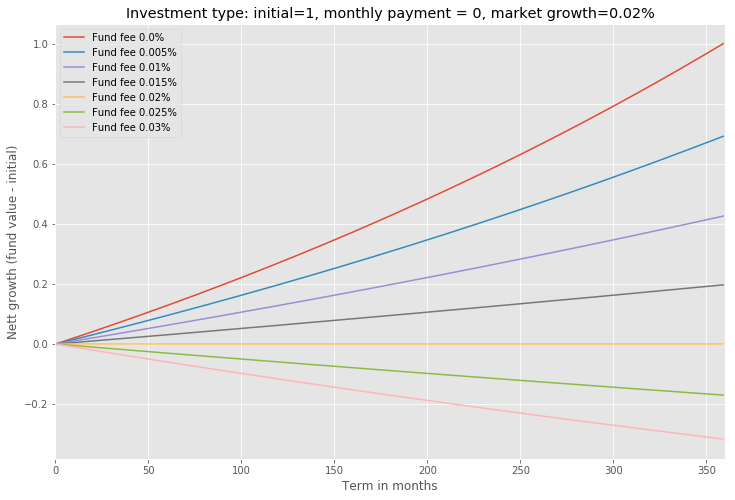

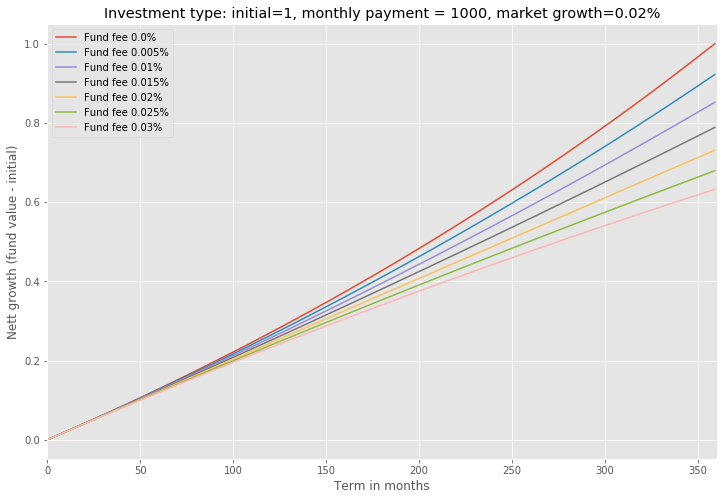

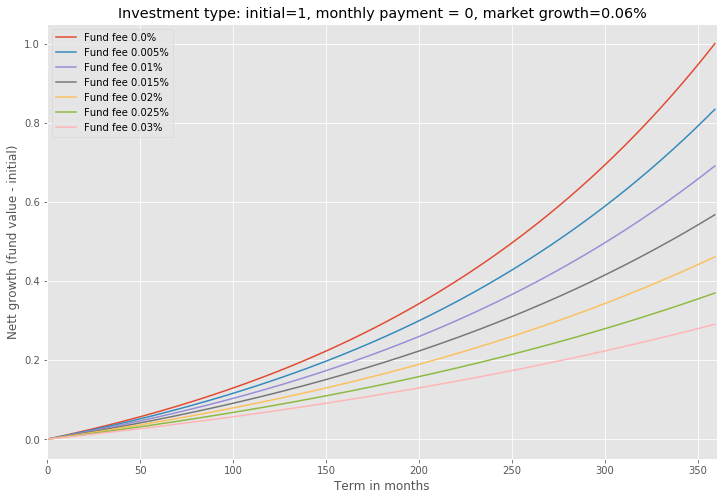

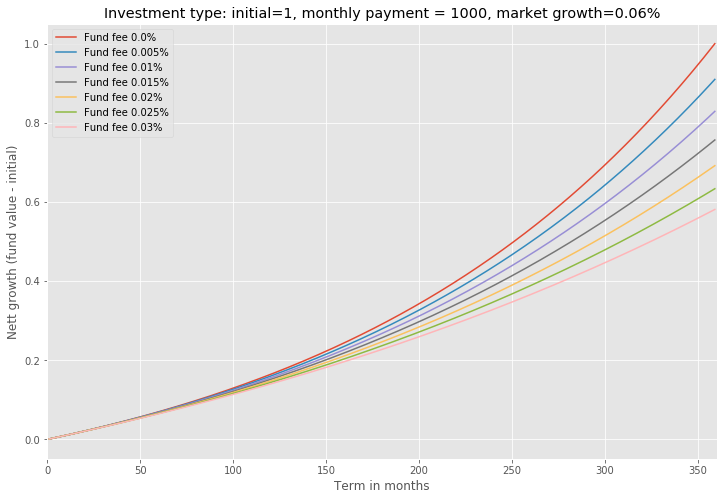

In [30]:
## to plot the investment growth
figsize(12,8)

for growthrate in growthrates:
    for i,addpayment in enumerate(addpayments):
        fig, axes = plt.subplots(nrows=1, ncols=1)
        dfa = dfSchedules.loc[(dfSchedules['AddPayment']==addpayment) & (dfSchedules['GrowthRate']==growthrate)]
        normval = dfa.loc[(dfa['costBalPcnt'] == 0)]['NettGrowth'].values[-1]
        for j,costBalPcnt in enumerate(costBalPcnts):
            df = dfa.loc[dfa['costBalPcnt']==costBalPcnt]
            df['NettGrowth'] /= normval
            df.reset_index().plot(x='Period',y='NettGrowth', label=f'Fund fee {costBalPcnt}%', ax=axes,xlim=[0,termyears*cyclesPerAnnum]    )
            axes.set_ylabel("Nett growth (fund value - initial)");
            axes.set_xlabel("Term in months");
            axes.set_title(f"Investment type: initial={initialvalue}, monthly payment = {addpayment}, market growth={growthrate}%");

# The following plots the end balance (not net growth)
if False:            
    for growthrate in growthrates:
        for i,addpayment in enumerate(addpayments):
            fig, axes = plt.subplots(nrows=1, ncols=1)
            dfa = dfSchedules.loc[(dfSchedules['AddPayment']==addpayment) & (dfSchedules['GrowthRate']==growthrate)]
            normval = dfa.loc[(dfa['costBalPcnt'] == 0)]['End Balance'].values[-1]
            for j,costBalPcnt in enumerate(costBalPcnts):
                df = dfa.loc[dfa['costBalPcnt']==costBalPcnt]
                df['End Balance'] /= normval
                df.reset_index().plot(x='Period',y='End Balance', label=f'Fund fee {costBalPcnt}%', ax=axes,xlim=[0,termyears*cyclesPerAnnum]    )
                axes.set_ylabel("Fund value");
                axes.set_xlabel("Term in months");
                axes.set_title(f"Investment type: initial={initialvalue}, monthly payment = {addpayment}, market growth={growthrate}%");            


The tables below summarises the *end balance* of various commission rates on the different types of investment.
The investment value is normalised to the ideal reference (no fees). 
Two tables are shown: for a 2% market growth and a 6% market growth.


The tables say the following:
    
1. If a lump sum only (no monthly additional payment) is invested with no future payments:
    1. a commission of 1% consumes 26% of the total investment value.
    1. a commission of 2% consumes 45% of the total investment value.
    1. a commission of 3% consumes 59% of the total investment value.


1. For a 6% market growth: if a minimal lump sum is invested followed up with much larger monthly future payments:
    1. a commission of 1% consumes 17% of the total investment value.
    1. a commission of 2% consumes 31% of the total investment value.
    1. a commission of 3% consumes 42% of the total investment value.
    
1. For a 2% market growth: if a minimal lump sum is invested followed up with much larger monthly future payments:
    1. a commission of 1% consumes 15% of the total investment value.
    1. a commission of 2% consumes 27% of the total investment value.
    1. a commission of 3% consumes 37% of the total investment value.
    
    These lower costs may seem 'smaller' as a percentage but recall that these are normalised to the zero cost case, which is also smaller because of the poor growth.
    
    

In [31]:
## calculate a normalised end balance for the different scenarios

dfSum['EndBalanceN'] = np.nan
AddPaymentU = dfSum['AddPayment'].unique()
for growthrate in growthrates:
    df = dfSum.loc[(dfSum['GrowthRate'] == growthrate) ]
    for addpayment in addpayments:
        normval = df.loc[(df['CostBalPcnt'] == 0) & (df['AddPayment'] == addpayment)]['EndBalance'].values[0]
        df.loc[df['AddPayment'] == addpayment,'EndBalanceN'] = (df.loc[df['AddPayment'] == addpayment,'EndBalance'])/normval

    dfp = pd.pivot_table(df, index=['CostBalPcnt'],values=['EndBalanceN'],columns=['AddPayment'])
    ufun.dispdfTable(dfp,doLaTeXdisplay,decimals=2,index=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The tables below summarises the *nett growth = end balance minus initial investment*  of various commission rates on the different types of investment.
The investment value is normalised to the ideal reference (no fees). 
Two tables are shown: for a 2% market growth and a 6% market growth.

For the scenario where the initial investment is small, followed by large monthly payments, the net growth is the same as before, because the initial value is very small compared to the end balance.

For the scenario where there is no additional payments and the only money invested is the lump sum, the nett growth can become negative if the fund fees exceed the growth. In the real world this means that the investment will have reduced to less than the initial amount invested  (negative net growth).
If the term is sufficiently long, the normalised net growth will be -1, meaning that the fund is depleted.

The results below show that at 3% fees and 2% market growth, the fund will have lost 32% of its value at the end of the term. This does not even account for the time value of money loss.

For the 3% fee and a 6% market growth, the nett growth over the full term would be 29% more than at the start.


In [32]:
## calculate a normalised net growth for the different scenarios
dfSum['NettGrowthN'] = np.nan
AddPaymentU = dfSum['AddPayment'].unique()
for growthrate in growthrates:
    df = dfSum.loc[(dfSum['GrowthRate'] == growthrate) ]
    for addpayment in addpayments:
        normval = df.loc[(df['CostBalPcnt'] == 0) & (df['AddPayment'] == addpayment)]['NettGrowth'].values[0]
        df.loc[df['AddPayment'] == addpayment,'NettGrowthN'] = (df.loc[df['AddPayment'] == addpayment,'NettGrowth'])/normval

    dfp = pd.pivot_table(df, index=['CostBalPcnt'],values=['NettGrowthN'],columns=['AddPayment'])
    ufun.dispdfTable(dfp,doLaTeXdisplay,decimals=2,index=True)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

To conclude this section, it is evident that high fees can severely erode the investment under poor market conditions.  

High fees can be as little as 1% and still have huge effect, because the percentage is on the full investment balance, not on the growth.
Considering that some of the fund values run into some hunderds of billions, it evident that the fund managers move very large sums of money as fees.

If the markets grow fast these effect of these fees is not so severe because the investment still grows at a rate equal to market minus fees. 
In poorly performing makets such as currently (2019) the fee percentage becomes significant to the growth percentage and the investment pays a significant penalty.



## Non-constant market growth

The results shown above is based on long term averages and does not account for short term market variations.
Most analysts agree that such calculations should rather be done with stochastic market movements.
I will do this some time in future.

## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [33]:
##to get software versions
# https://github.com/rasbt/watermark
# https://github.com/rasbt/watermark/blob/master/docs/watermark.ipynb
# you only need to do this once
# pip install watermark
# conda install -c conda-forge watermark

%load_ext watermark
%watermark -v -m -p numpy,scipy -g 
print()


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : c79dec25ffb2d3ed1d5d443ee84cb0e171165a8a



In [34]:
## to print the last update date
print('Last Updated On: ', datetime.now()) 

Last Updated On:  2019-02-26 10:26:43.785000
